# Gaussianization Flows (Details)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
# import pytorch_lightning as pl
# from torchvision.datasets import MNIST

# from torchvision import transforms
# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader
# from rbig_jax.data import GenericDataset

In [4]:
from rbig_jax.custom_types import ImageShape
from rbig_jax.transforms.reshape import flatten_image, unflatten_image
from rbig_jax.datasets.mnist import MNISTDataModule
from typing import Optional

image_shape = ImageShape(C=1, H=28, W=28)

In [5]:
# initialize loader
from pathlib import Path

dataset_dir = str(Path(root).joinpath("datasets/mnist"))
mnist_module = MNISTDataModule(
    subset=5_000, dataset_dir=dataset_dir, downscale_factor=3
)

# prepare and setup
mnist_module.prepare_data()
mnist_module.setup()

In [6]:
train_dl = mnist_module.train_dataloader()
valid_dl = mnist_module.valid_dataloader()

In [7]:
from rbig_jax.transforms.reshape import flatten_image, unflatten_image

In [8]:
X = mnist_module.Xtrain


rng = np.random.RandomState(123)


# naive dequantization
X += rng.rand(*X.shape)

# scale data
X_train = X / 256.0

# downsize image and reshape
# X_train = unflatten_image(X_train, mnist_module.image_shape, batch=True)

# X_train = downscale_local_mean(X_train, (1, 3, 3, 1))
# print(X_train.shape)
# image_shape = ImageShape(C=1, H=10, W=10)

# X_train = flatten_image(X_train, image_shape, batch=True)

# subset
data = X_train

data.shape

(5000, 100)

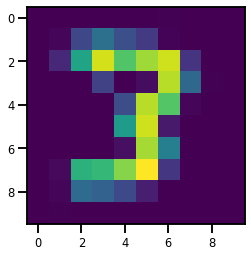

In [9]:
plt.imshow(unflatten_image(data[0], mnist_module.image_shape, batch=False))

### Image Shape

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f9930698fd0>)

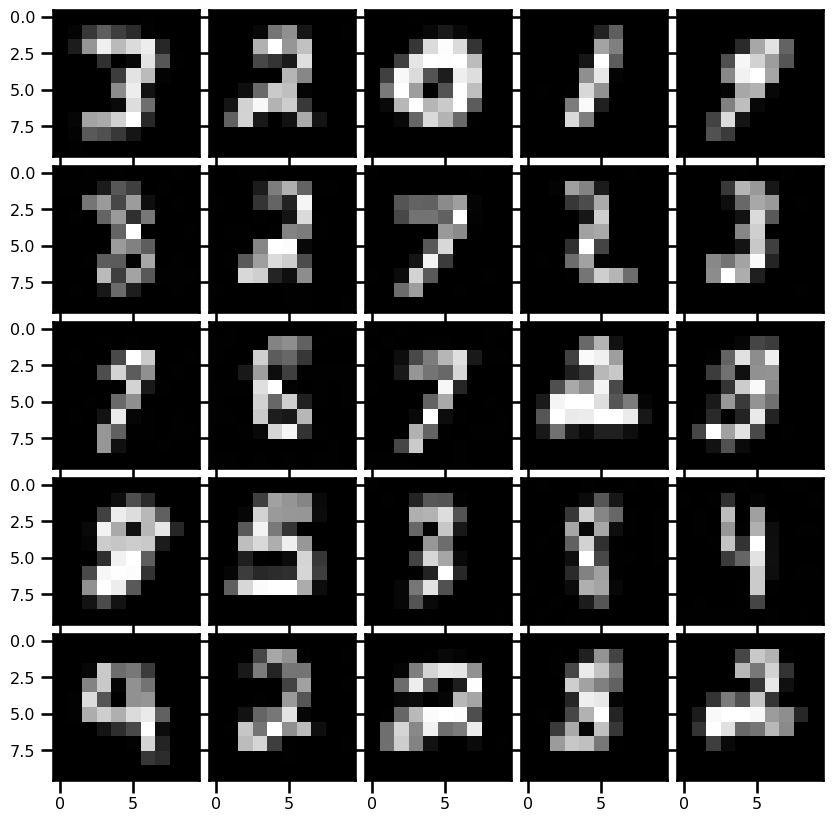

In [10]:
from rbig_jax.plots import plot_image_grid

plot_image_grid(data, mnist_module.image_shape)

## Model Inputs

In [11]:
# X = flatten_image(data, image_shape, batch=True)
X = jnp.array(data[:10_000], dtype=jnp.float64)
X.shape

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2892: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


(5000, 100)

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f98dc621220>)

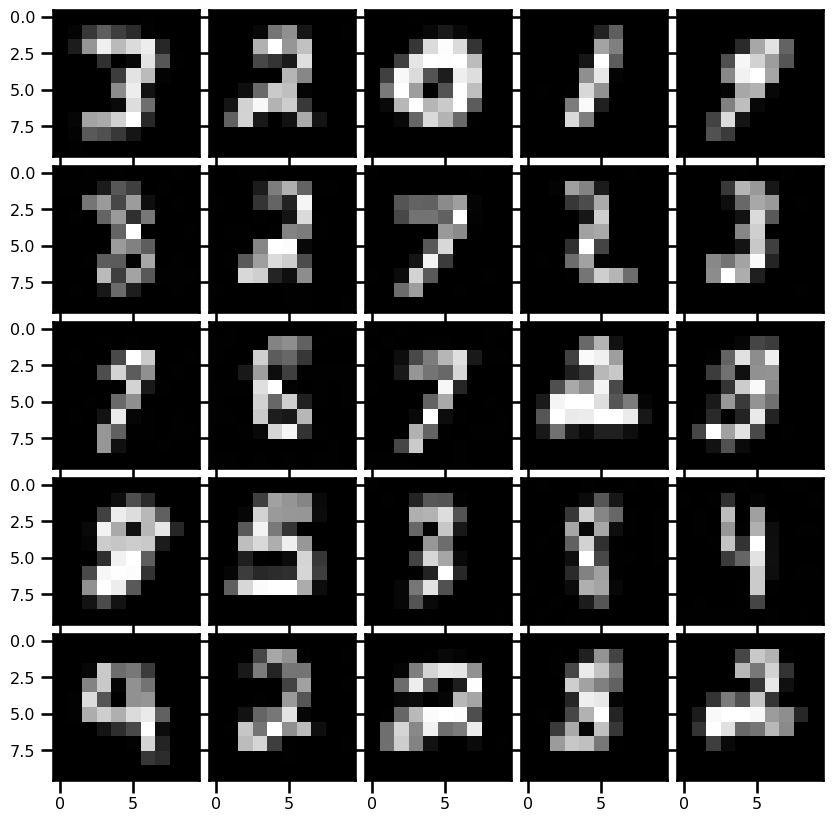

In [12]:
plot_image_grid(X, mnist_module.image_shape)

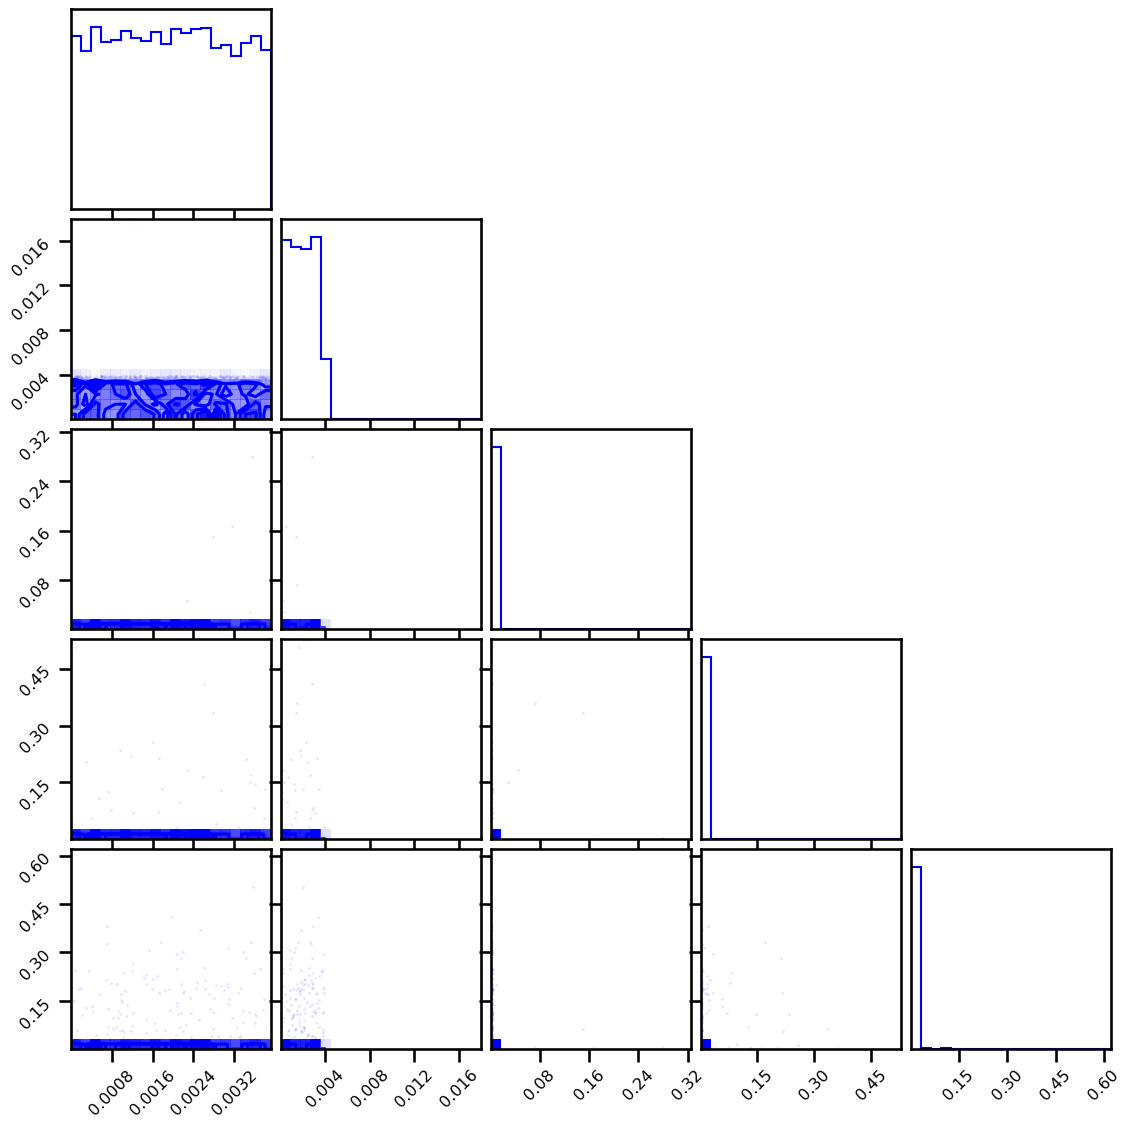

In [49]:
fig = corner.corner(np.array(X[:, :5]), color="Blue")

## Model - Naive

In [13]:
from rbig_jax.models.gaussflow import init_default_gf_model

In [32]:
n_blocks = 2
n_reflections = 2  # X.shape[1] // 2 + 1
mixture = "gaussian"
inverse_cdf = "gaussian"
init_mixcdf = "random"
init_rotation = "random"
plot_layers = False
plot_blocks = False
X_init = np.array(X[:5_000])

# init model
gf_model = init_default_gf_model(
    shape=X.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    init_mixcdf=init_mixcdf,
    init_rotation=init_rotation,
    inverse_cdf=inverse_cdf,
    mixture=mixture,
    n_reflections=n_reflections,
    plot_layers=plot_layers,
)

Initializing - Block: 2 | Layer 5: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


In [33]:
%%time

X_g = gf_model.forward(X)

CPU times: user 4.59 s, sys: 1.72 s, total: 6.3 s
Wall time: 1.47 s


In [34]:
X.shape

(5000, 100)

In [35]:
X_g.shape, X_g.min(), X_g.max()

((5000, 100),
 DeviceArray(-1.0831202, dtype=float32),
 DeviceArray(1.3808669, dtype=float32))

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f9607d1c580>)

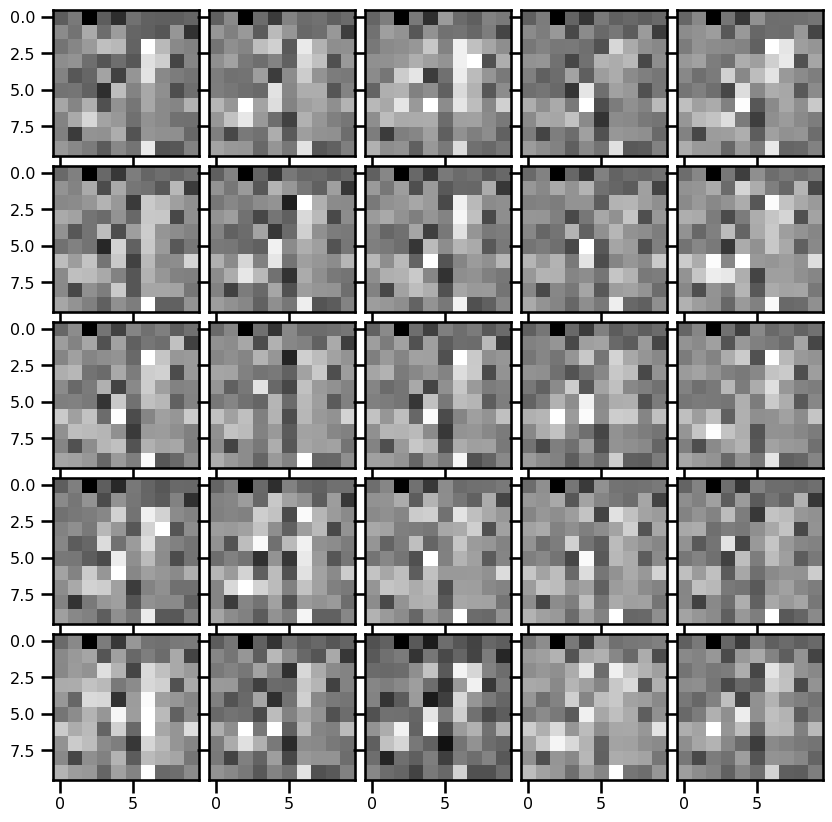

In [36]:
# plot data
plot_image_grid(X_g, mnist_module.image_shape)

#### Training

In [ ]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


# lr = 0.05
lr = 5e-3
optimizer = optimizers.adam(step_size=lr)
jitted = True
# epochs = 150
epochs = 100

# train model
final_bijector, losses = train_model(
    gf_model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    epochs=epochs,
    optimizer=optimizer,
    jitted=jitted,
)

 21%|██        | 21/100 [16:28<1:00:28, 45.93s/it, Train Loss=33823.1016, Valid Loss=33751.2422] 

### Results

#### Losses

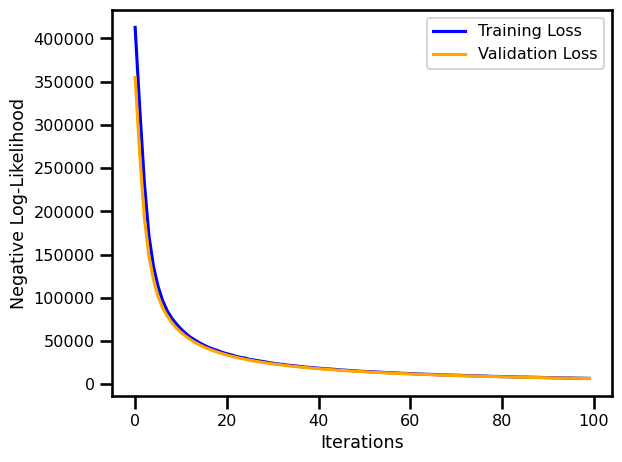

In [38]:
fig, ax = plt.subplots()
ax.plot(losses["train"], label="Training Loss", color="blue")
ax.plot(losses["valid"], label="Validation Loss", color="orange")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
X_g = final_bijector.forward(X)

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f95ef7f2820>)

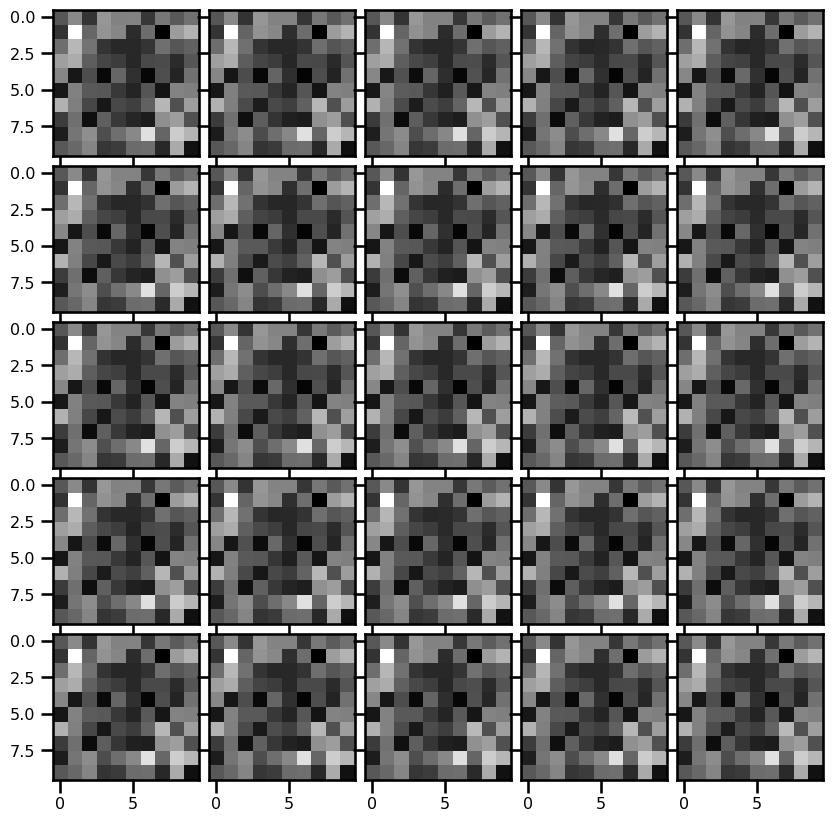

In [42]:
plot_image_grid(X_g, mnist_module.image_shape)

#### Latent Space

In [ ]:
# plot data
plot_image_grid(X_g, mnist_module.image_shape)

In [43]:
X_g.shape

(5000, 100)

CPU times: user 7.33 s, sys: 1.86 s, total: 9.19 s
Wall time: 4.36 s


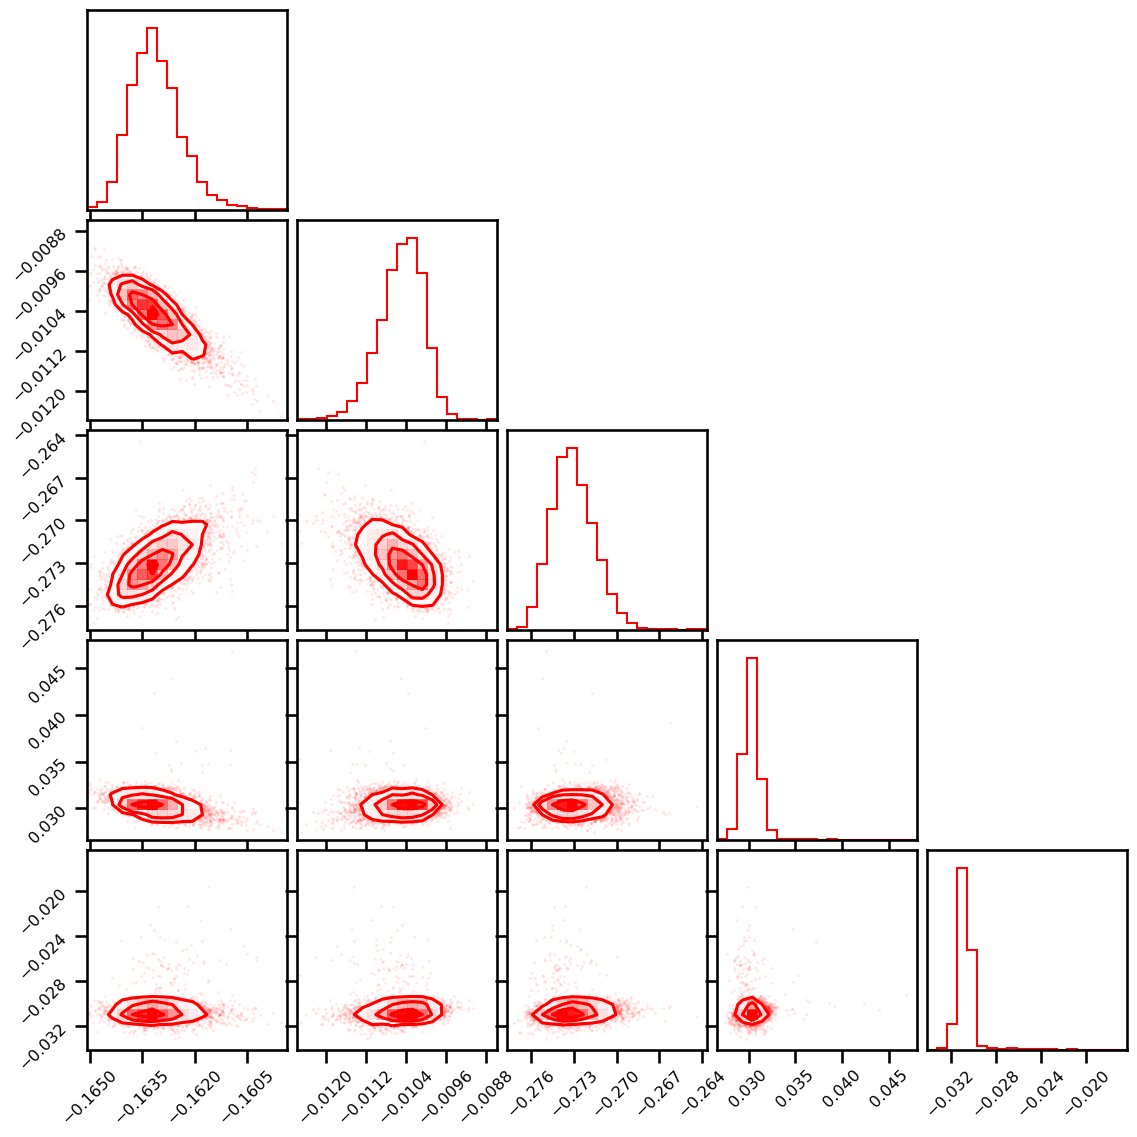

In [44]:
%%time
X_trans = final_bijector.forward(data)

fig = corner.corner(np.array(X_g[:, :5]), color="Red")

#### Inverse Transform

In [45]:
%%time

X_approx = final_bijector.inverse(X_trans)

CPU times: user 35min 40s, sys: 5.97 s, total: 35min 46s
Wall time: 2min 2s


(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f9740348a00>)

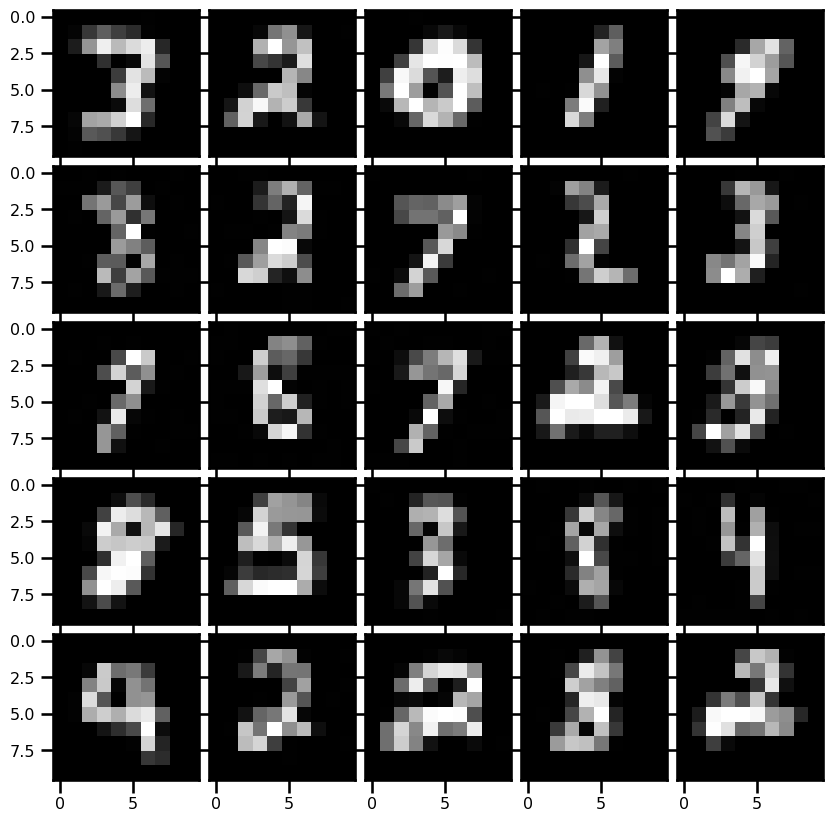

In [46]:
# plot data
plot_image_grid(np.array(X_approx), mnist_module.image_shape)

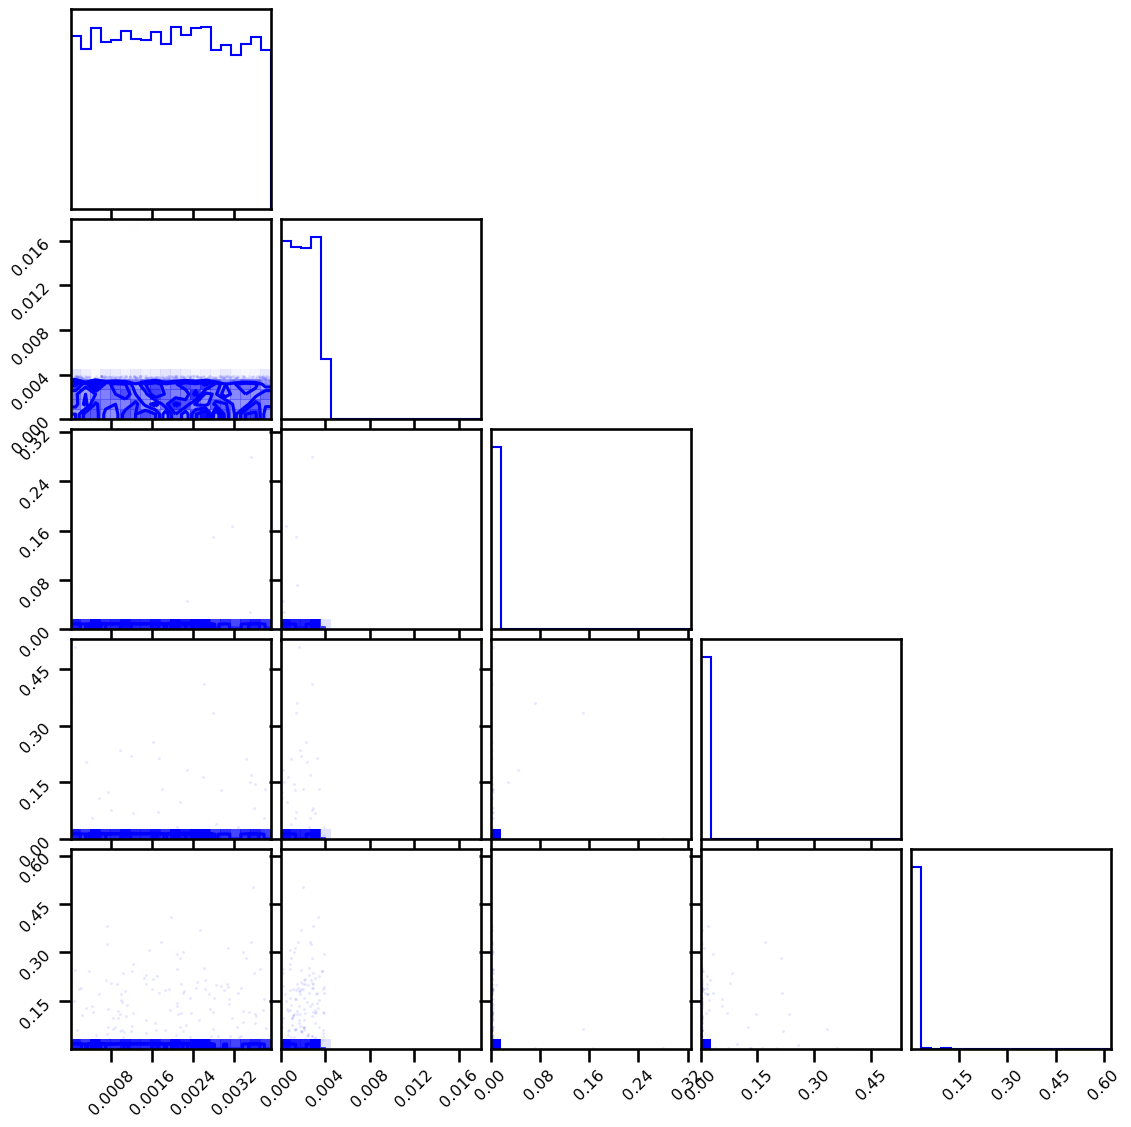

In [48]:
fig = corner.corner(np.array(X_approx[:, :5]), color="Blue")

### Log Probability

In [27]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(X, 500, buffer=0.2)

# calculate log probability
X_log_prob = final_bijector.score_samples(xyinput)

CPU times: user 6.03 s, sys: 1.95 s, total: 7.98 s
Wall time: 3.35 s


### Sampling

In [50]:
%%time
n_gen_samples = 1_000
X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 7min 12s, sys: 4.33 s, total: 7min 16s
Wall time: 34.7 s


(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f974030d400>)

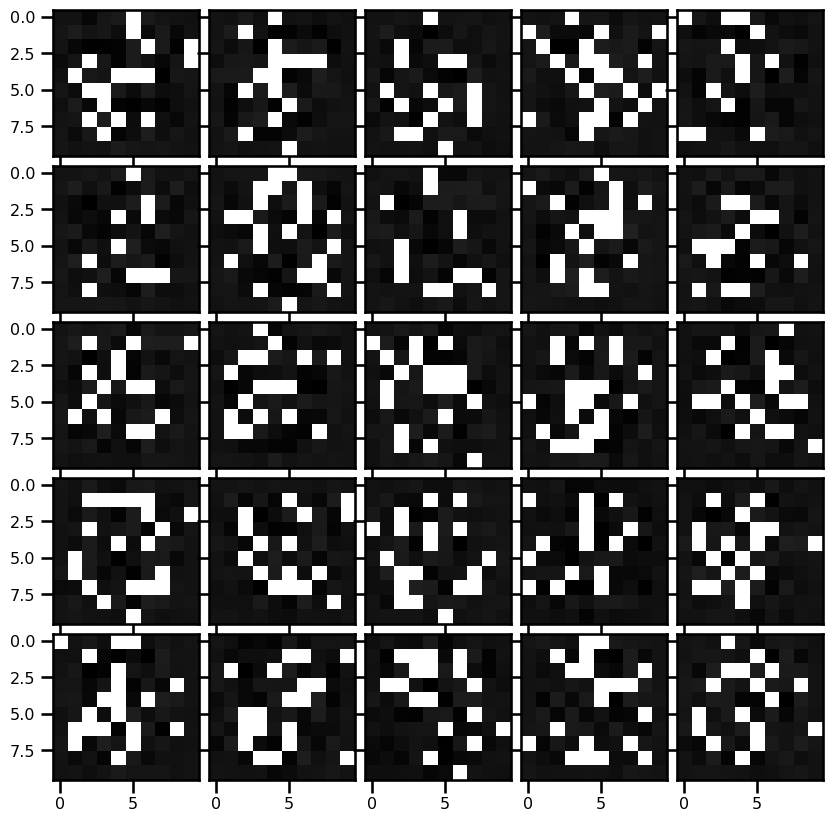

In [51]:
# plot data
plot_image_grid(np.array(X_samples), mnist_module.image_shape)

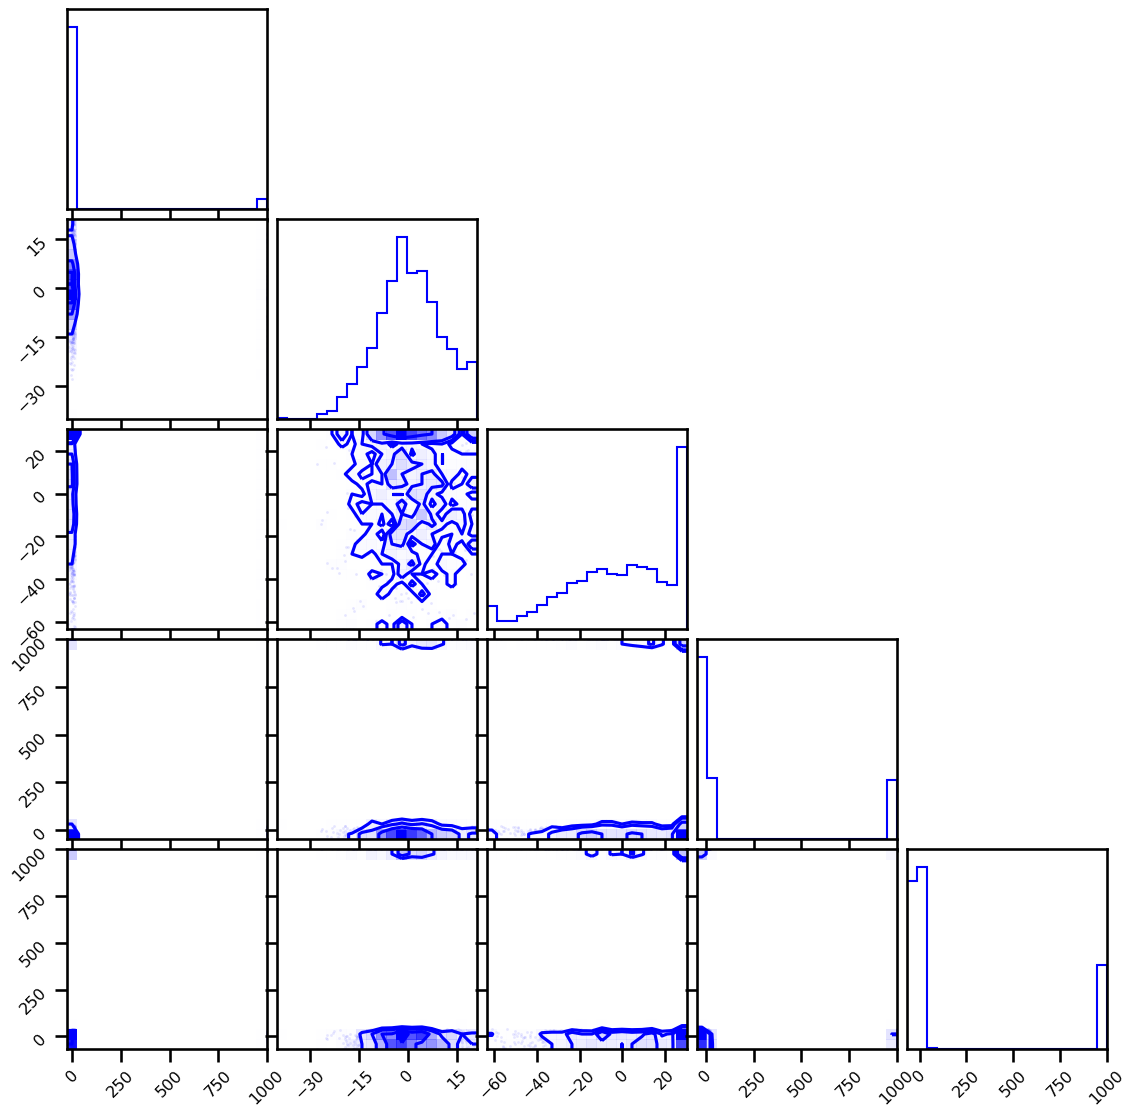

In [52]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

## Each Layer

#### Original

In [ ]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    

#### Trained Model

In [ ]:

X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [54]:
import joblib

#### Save Model

In [55]:
joblib.dump(final_bijector, "rbig_model_mnist.pickle")

['rbig_model_mnist.pickle']

#### Load Model

In [56]:
rbig_model_ = joblib.load("rbig_model_mnist.pickle")